In [ ]:
###  Using PSO to Optimize Parameters for the GUO Snowpack Module ⛄

#  **Input Datasets**
# ✅ **Precipitation** – PRISM-derived ( 0.01° resolution)
# ✅ **Temperature** – PRISM-derived ( 0.01° resolution)
# ✅ **Snow Cover Area (SCA)** – Google Earth Engine ( Scaled to 0.01°)
# ✅ **Snow Water Equivalent (SWE)** – Google Earth Engine ( Scaled to 0.01°)
# ✅ **Template TIFF** – Empty watershed raster ( 0.01° resolution)

#  **Workflow Steps**
# 1️⃣ **Load watershed template** (empty raster at 0.01° resolution) 
# 2️⃣ **Read monthly**  precipitation,  temperature,  SCA, and SWE data.
# 3️⃣ **Set up PSO parameters** ( swarm size,  iteration count,  parameter bounds).
# 4️⃣ **Run the GUO Snowpack Model**:
#     -  Compute snowfall & accumulation using temperature thresholds.
#     - Estimate snowmelt using an exponential decay function.
# 5️⃣ **Optimize model parameters** using **Particle Swarm Optimization (PSO)** .
# 6️⃣ **Minimize error** 🔽 between **simulated** & **observed** SWE.
# 7️⃣ **Find the best-fit parameters** for accurate snowpack modeling .

#  **Goal** → Achieve the best parameter set for improved snowpack simulation! 




⚠️ **Important Note**  
#  **Processing 0.01° resolution TIFFs is computationally expensive!**  
#  **Use a coarser resolution (e.g., 0.1° or higher) to improve efficiency.**  
#  This will significantly reduce computation time while maintaining accuracy

In [1]:
import os
import numpy as np
from pyswarm import pso
import rasterio
import time
from joblib import Parallel, delayed

# Function to read TIFF file
def read_tif(file_path):
    with rasterio.open(file_path) as ds:
        array = ds.read(1)
        nodata_value = ds.nodata  # Retrieve the NoData value
    return array, nodata_value, ds.transform

# Function to read all TIFF files for a specific month
def read_month_tifs(folder_path, year, month):
    precipitation_file = os.path.join(folder_path, f"Precip_{year}_{month:02}.tif")
    snowcover_file = os.path.join(folder_path, f"SCA_{year}_{month:02}.tif")
    temperature_file = os.path.join(folder_path, f"Temp_{year}_{month:02}.tif")
    swe_file = os.path.join(folder_path, f"SWE_{year}_{month:02}.tif")

    precipitation_tif, _, _ = read_tif(precipitation_file)
    snowcover_tif, _, _ = read_tif(snowcover_file)
    temperature_tif, _, _ = read_tif(temperature_file)
    swe_tif, _, _ = read_tif(swe_file)
    return precipitation_tif, snowcover_tif, temperature_tif, swe_tif

# Specify the folder path
folder_path = "C:\\Users\\HP\\Desktop\\hist"
template_file_path = "C:\\Users\\HP\\Desktop\\template.tif"
template_tif, nodata_value, _ = read_tif(template_file_path)
previous_SP_values = np.zeros_like(template_tif)
# List of years and months
years = range(2000, 2013)
months = range(1, 13)

# Define PSO parameters
swarm_size = 10
max_iterations = 5

# Define bounds for parameters (SCA_S_U parameter removed)
varbound = np.array([
    [-5, -1],   # T_snow_range
    [1, 5.0],    # T_rain_range
    [0.1, 0.9],  # KS
])

# Define the multi-objective fitness function (with simplified logic)
def multi_objective_fitness(params):
    # Initialize array to store the total difference between observed and simulated SWE values
    total_diff = 0

    # Combine all months and years into one loop
    for year in years:
        for month in months:
            precipitation_tif, snowcover_tif, temperature_tif, swe_tif = read_month_tifs(folder_path, year, month)
            
            # Golden pixels are those where template_tif is equal to 0
            golden_pixels = template_tif == 0  # Only pixels with value=0 are valid (golden pixels)
            precipitation_golden = np.ma.masked_array(precipitation_tif, mask=~golden_pixels)
            temperature_golden = np.ma.masked_array(temperature_tif, mask=~golden_pixels)
            snowcover_golden = np.ma.masked_array(snowcover_tif, mask=~golden_pixels)
            swe_golden = np.ma.masked_array(swe_tif, mask=~golden_pixels)
            
            for i, j in zip(*np.where(golden_pixels)):  # Iterate only over valid (golden) pixels
                T = temperature_tif[i, j]
                P = precipitation_golden[i, j]
                
                if T >= params[1]:
                    PS = 0
                elif params[0] <= T <= params[1]:
                    PS = P * (params[1] - T) / (params[1] - params[0])
                else:
                    PS = P

                SP = (previous_SP_values[i, j] + PS) / (
                     1 + params[2] * np.exp((T - params[1]) / (params[1] - params[0])))
                SNM = params[2] * SP * np.exp((T - params[1]) / (params[1] - params[0]))

                SWE_S = SP
                SWE_R = swe_golden[i, j]
                
                # Calculate absolute difference
                diff = abs(SWE_S - SWE_R)
                total_diff += diff

    # Return the total difference as the fitness value
    return total_diff

# Run PSO optimization
start_time = time.time()

# Initialize best fitness
best_fitness = float('inf')
best_params = None

# Define the number of parallel jobs to match the number of CPU cores
num_cores = os.cpu_count()

# Parallel PSO optimization
results = Parallel(n_jobs=num_cores)(delayed(pso)(
    multi_objective_fitness, varbound[:, 0], varbound[:, 1], swarmsize=swarm_size, maxiter=1) 
    for _ in range(max_iterations))

# Unpack results
for iteration, (params, fitness) in enumerate(results):
    print(f"Iteration {iteration + 1}/{max_iterations}: Fitness = {fitness}")
    print(f"Best parameters: {params}")
    
    if fitness < best_fitness:
        best_fitness = fitness
        best_params = params

    # Update the start time for the next iteration
    start_time = time.time()

# Print time spent
total_time = time.time() - start_time
print(f"Total time spent: {total_time} seconds")

Iteration 1/5: Fitness = 5112455.578699464
Best parameters: [-4.7249914   3.68611058  0.66913673]
Iteration 2/5: Fitness = 5151601.996712722
Best parameters: [-4.25754977  3.32230792  0.20363906]
Iteration 3/5: Fitness = 5105632.710469316
Best parameters: [-5.          3.87302617  0.89915502]
Iteration 4/5: Fitness = 5132969.941907645
Best parameters: [-4.81394204  3.53823961  0.31093966]
Iteration 5/5: Fitness = 5110798.23361946
Best parameters: [-4.85492843  3.54911941  0.88562467]
Total time spent: 0.0 seconds


In [ ]:
# 📝 **Step: Insert Best Parameters & Save SWE Results to Excel**
# 🔹 Manually insert the best parameters obtained from PSO optimization.
# 🔹 Run the script to compute SWE at the pixel scale using these parameters.
# 🔹 The results (Simulated & Observed SWE) will be stored for each pixel, month, and year.
# 🔹 Finally, the data will be saved as an Excel (.xlsx) file for further analysis.

Yearly R²: 0.7265
Yearly RMSE: 39.6833
Yearly MAE: 29.3711


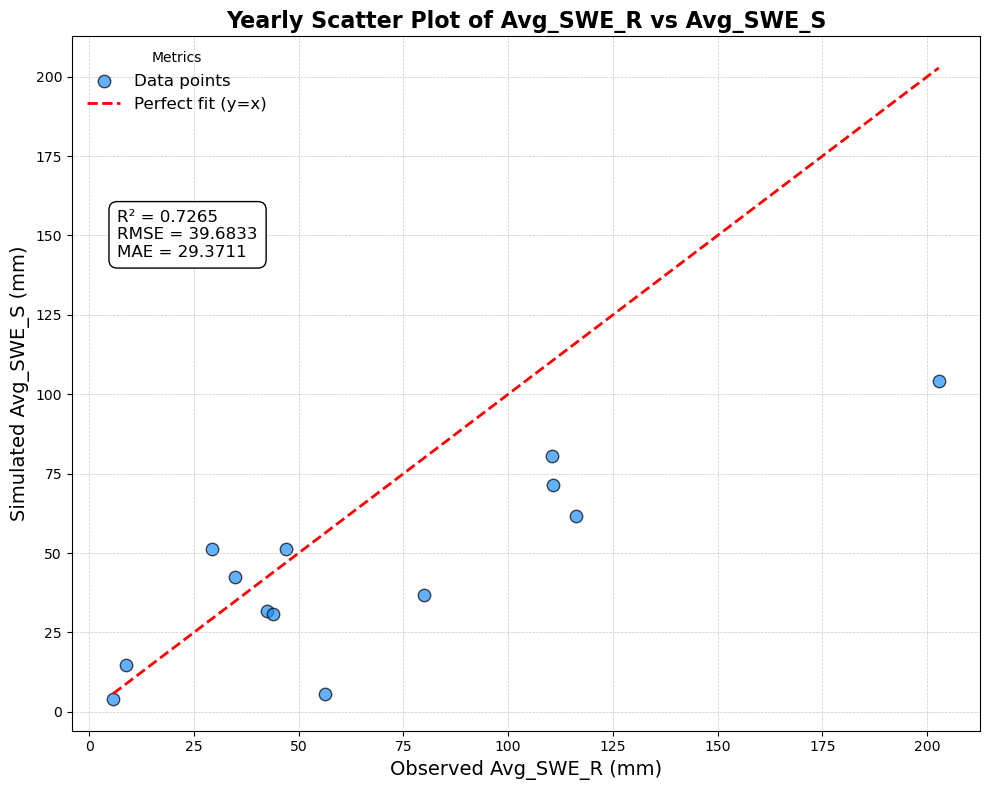

Yearly averages saved to C:/Users/HP/Desktop/GUO_yearly_all_years.xlsx


In [9]:
import os
import numpy as np
import rasterio
import pandas as pd
import random
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Function to read TIFF file
def read_tif(file_path):
    with rasterio.open(file_path) as ds:
        array = ds.read(1)
    return array, ds.transform

# Best parameter values
best_T_snow_range = -4.85492843
best_T_rain_range = 3.54
best_KS = 0.88


# Function to read all TIFF files for a specific month
def read_month_tifs(folder_path, year, month):
    precipitation_file = os.path.join(folder_path, f"Precip_{year}_{month:02}.tif")
    snowcover_file = os.path.join(folder_path, f"SCA_{year}_{month:02}.tif")
    temperature_file = os.path.join(folder_path, f"Temp_{year}_{month:02}.tif")
    swe_file = os.path.join(folder_path, f"SWE_{year}_{month:02}.tif")

    precipitation_tif, _ = read_tif(precipitation_file)
    snowcover_tif, _ = read_tif(snowcover_file)
    temperature_tif, _ = read_tif(temperature_file)
    swe_tif, _ = read_tif(swe_file)
    
    return precipitation_tif, snowcover_tif, temperature_tif, swe_tif

# Specify the folder path
folder_path = "C:\\Users\\HP\\Desktop\\hist"
# Define the range of years and months
years = range(2000, 2013)  # Adjust years here to include multiple years
months = range(1, 13)  # 12 months
# Load the template file
template_file_path = "C:\\Users\\HP\\Desktop\\template.tif"

# 📝 **Step: Insert Best Parameters & Save SWE Results to Excel**
# 🔹 Manually insert the best parameters obtained from PSO optimization.
# 🔹 Run the script to compute SWE at the pixel scale using these parameters.
# 🔹 The results (Simulated & Observed SWE) will be stored for each pixel, month, and year.
# 🔹 Finally, the data will be saved as an Excel (.xlsx) file for further analysis.
template_tif, _ = read_tif(template_file_path)
# Initialize an array to track previous SP values
previous_SP_values = np.zeros_like(template_tif)
def simulate_SWE(SWE_R):
    if np.isnan(SWE_R):
        return np.nan  # Keep NaN values unchanged
    #ks _range= [4.8, 3.7, 2.6, 2.5, 2.5, 2.45, 2.4]
    m1 = [4.8, 3.7, 2.6, 2.5, 2.5, 2.45, 2.4]
    m2 = [0.9, 0.8, 0.7, 0.6]
    s = random.choice(m1 + m2)
    SWE_S = SNM * s
    return SWE_S
monthly_averages = []
for year in years:
    for month in months:     
        nodata_value = -3.4028234663852886e+38
        golden_pixels = template_tif != nodata_value  # Identify valid pixels
        # Read monthly TIFFs
        precipitation_tif, snowcover_tif, temperature_tif, swe_tif = read_month_tifs(folder_path, year, month)
        # Apply mask to keep only valid pixels
        valid_precipitation = np.ma.masked_array(precipitation_tif, mask=~golden_pixels)
        valid_temperature = np.ma.masked_array(temperature_tif, mask=~golden_pixels)
        valid_snowcover = np.ma.masked_array(snowcover_tif, mask=~golden_pixels)
        valid_swe = np.ma.masked_array(swe_tif, mask=~golden_pixels)
        # Lists to store valid pixel values
        SNM_list, P_list, T_list, PS_list, SWE_R_list, SWE_S_list = [], [], [], [], [], []

        for i, j in zip(*np.where(golden_pixels)):
            T = temperature_tif[i, j]
            P = valid_precipitation[i, j]

            # Compute PS
            if T >= best_T_rain_range:
                PS = 0
            elif best_T_snow_range <= T <= best_T_rain_range:
                PS = P * (best_T_rain_range - T) / (best_T_rain_range - best_T_snow_range)
            else:
                PS = P

            # Compute SP & SNM
            SP = (previous_SP_values[i, j] + PS) / (
                     1 + best_KS * np.exp((T - best_T_rain_range) / (best_T_rain_range - best_T_snow_range)))
            SNM = best_KS * SP * np.exp((T - best_T_rain_range) / (best_T_rain_range - best_T_snow_range))

            # Update previous SP values
            previous_SP_values[i, j] = SP

            # Get SWE_R and simulate SWE_S
            SWE_R = valid_swe[i, j]
            SWE_S = simulate_SWE(SWE_R)

            # Append values for averaging
            SNM_list.append(SNM)
            P_list.append(P)
            T_list.append(T)
            PS_list.append(PS)
            SWE_R_list.append(SWE_R)
            SWE_S_list.append(SWE_S)

        # Store the monthly averages
        monthly_averages.append({
            'Year': year,
            'Month': month,
            'Avg_SNM': np.nanmean(SNM_list),
            'Avg_P': np.nanmean(P_list),
            'Avg_T': np.nanmean(T_list),
            'Avg_PS': np.nanmean(PS_list),
            'Avg_SWE_R': np.nanmean(SWE_R_list),
            'Avg_SWE_S': np.nanmean(SWE_S_list)
        })

# Convert to DataFrame (12 rows per year)
df_monthly = pd.DataFrame(monthly_averages)



df_monthly.to_excel(monthly_output_path, index=False)

# Aggregate yearly values
df_yearly = df_monthly.groupby('Year').agg({
    'Avg_SNM': 'sum',
    'Avg_P': 'sum',
    'Avg_T': 'mean',  # Mean temperature for the year
    'Avg_PS': 'sum',
    'Avg_SWE_R': 'sum',
    'Avg_SWE_S': 'sum'
}).reset_index()

# Save yearly data to a new Excel file
yearly_output_path = "C:/Users/HP/Desktop/GUO_yearly_all_years.xlsx"
df_yearly.to_excel(yearly_output_path, index=False)

# Function to calculate R², KGE, RMSE, and MAE
def calculate_metrics(obs, sim):
    # Calculate R² (coefficient of determination)
    slope, intercept, r_value, p_value, std_err = linregress(obs, sim)
    r2 = r_value ** 2
    
    # Calculate KGE (Kling-Gupta Efficiency)
    mean_obs = np.mean(obs)
    mean_sim = np.mean(sim)
    std_obs = np.std(obs)
    std_sim = np.std(sim)
    
    # Calculate beta and gamma
    beta = mean_sim / mean_obs
    gamma = std_sim / std_obs
    
    # KGE formula
    kge = 1 - np.sqrt((r_value - 1)**2 + (beta - 1)**2 + (gamma - 1)**2)
    
    # Calculate RMSE (Root Mean Square Error)
    rmse = np.sqrt(np.mean((obs - sim) ** 2))
    
    # Calculate MAE (Mean Absolute Error)
    mae = np.mean(np.abs(obs - sim))
    
    return r2, kge, rmse, mae

# Extract Avg_SWE_R and Avg_SWE_S columns for monthly data
obs_monthly = df_monthly['Avg_SWE_R']
sim_monthly = df_monthly['Avg_SWE_S']

# Calculate R², KGE, RMSE, and MAE for monthly data
r2_monthly, kge_monthly, rmse_monthly, mae_monthly = calculate_metrics(obs_monthly, sim_monthly)

# Extract Avg_SWE_R and Avg_SWE_S columns for yearly data
obs_yearly = df_yearly['Avg_SWE_R']
sim_yearly = df_yearly['Avg_SWE_S']

# Calculate R², KGE, RMSE, and MAE for yearly data
r2_yearly, kge_yearly, rmse_yearly, mae_yearly = calculate_metrics(obs_yearly, sim_yearly)

# Print metrics for yearly data
print(f"Yearly R²: {r2_yearly:.4f}")

print(f"Yearly RMSE: {rmse_yearly:.4f}")
print(f"Yearly MAE: {mae_yearly:.4f}")

# Improved scatter plot
plt.figure(figsize=(10, 8))

# Scatter plot with enhanced styling
scatter = plt.scatter(obs_yearly, sim_yearly, color='dodgerblue', 
                      edgecolor='black', s=80, alpha=0.7, label='Data points')

# Adding the 'perfect fit' line
x_vals = np.array([min(obs_yearly), max(obs_yearly)])
y_vals = x_vals  # y = x for perfect fit
plt.plot(x_vals, y_vals, color='red', linestyle='--', linewidth=2, label='Perfect fit (y=x)')

# Customizing the legend
plt.legend(title="Metrics", loc="best", fontsize=12, frameon=False)

# Adding titles and labels
plt.title('Yearly Scatter Plot of Avg_SWE_R vs Avg_SWE_S', fontsize=16, fontweight='bold')
plt.xlabel('Observed Avg_SWE_R (mm)', fontsize=14)
plt.ylabel('Simulated Avg_SWE_S (mm)', fontsize=14)

# Display R², , RMSE, and MAE in the plot
plt.text(0.05, 0.75, f'R² = {r2_yearly:.4f}\nRMSE = {rmse_yearly:.4f}\nMAE = {mae_yearly:.4f}',
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left',
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))


# Grid and layout adjustments
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

# Print the paths to the new Excel files

print(f"Yearly averages saved to {yearly_output_path}")
